In [35]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from git_analysis import AssocAnalyzer, ModelParams, HierarchyType
from gen_callgraph_wrapper import GRAPH_DIR
from graph import raw_graph_to_igraph
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.basicConfig()
logging.getLogger("git_processor").setLevel(logging.INFO)
logging.getLogger("java_change_detector").setLevel(logging.ERROR)
logging.getLogger("assoc_mining").setLevel(logging.INFO)
ana = AssocAnalyzer("https://github.com/skylot/jadx")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:git_processor:Using pre-existing git repository at C:\dev\gitAnalysis\GIT_REPOS\jadx
INFO:git_processor:Using pre-existing cache at C:\dev\gitAnalysis\GIT_REPOS_SHELVE\jadx
INFO:git_processor:Processing git repository located at C:\dev\gitAnalysis\GIT_REPOS\jadx


In [55]:
params = {
    "jadx - Commits - methods": ModelParams("commit", HierarchyType.method, min_support=0.005, min_confidence=0),
    "jadx - Commits - type declarations": ModelParams("commit", HierarchyType.type_def, min_support=0.005, min_confidence=0),
    "jadx - Commits - packages": ModelParams("commit", HierarchyType.package, min_support=0.005, min_confidence=0),
    "jadx - Pull requests - methods": ModelParams("pr", HierarchyType.method, min_support=0.005, min_confidence=0),
    "jadx - Pull requests - type declarations": ModelParams("pr", HierarchyType.type_def, min_support=0.005, min_confidence=0),
    "jadx - Pull requests - packages": ModelParams("pr", HierarchyType.package, min_support=0.005, min_confidence=0)
}
models = {
    s: ana.analyze_model(v)
    for s, v in params.items()
}
for k, v in models.items():
    g = ana.create_graph(v)
    g.to_folder(GRAPH_DIR / k)

# g = ana.create_graph(model)
# model.params, model.describe()
# g.to_folder(GRAPH_DIR / f"jadx-git-{g.hash}")

s

In [29]:
stat_df = pd.DataFrame.from_records([{
    "item type": v.params.hierarchy_type.name,
    "basket type": v.params.commit_or_pr,
    "#baskets": len(v.one_hot),
    "#items": len(v.one_hot.columns),
} for v in models.values()])

pd.pivot(stat_df, ["basket type", "item type"], [])

#baskets  #items
basket type item type                  
commit      method         1423   13359
            type_def       1452    2888
            package        1455     192
pr          method          248    4343
            type_def        254    1072
            package         254     106

In [48]:
v.assoc_rules["support"].describe()

count    4536.000000
mean        0.018784
std         0.013323
min         0.007874
25%         0.011811
50%         0.015748
75%         0.023622
max         0.118110
Name: support, dtype: float64

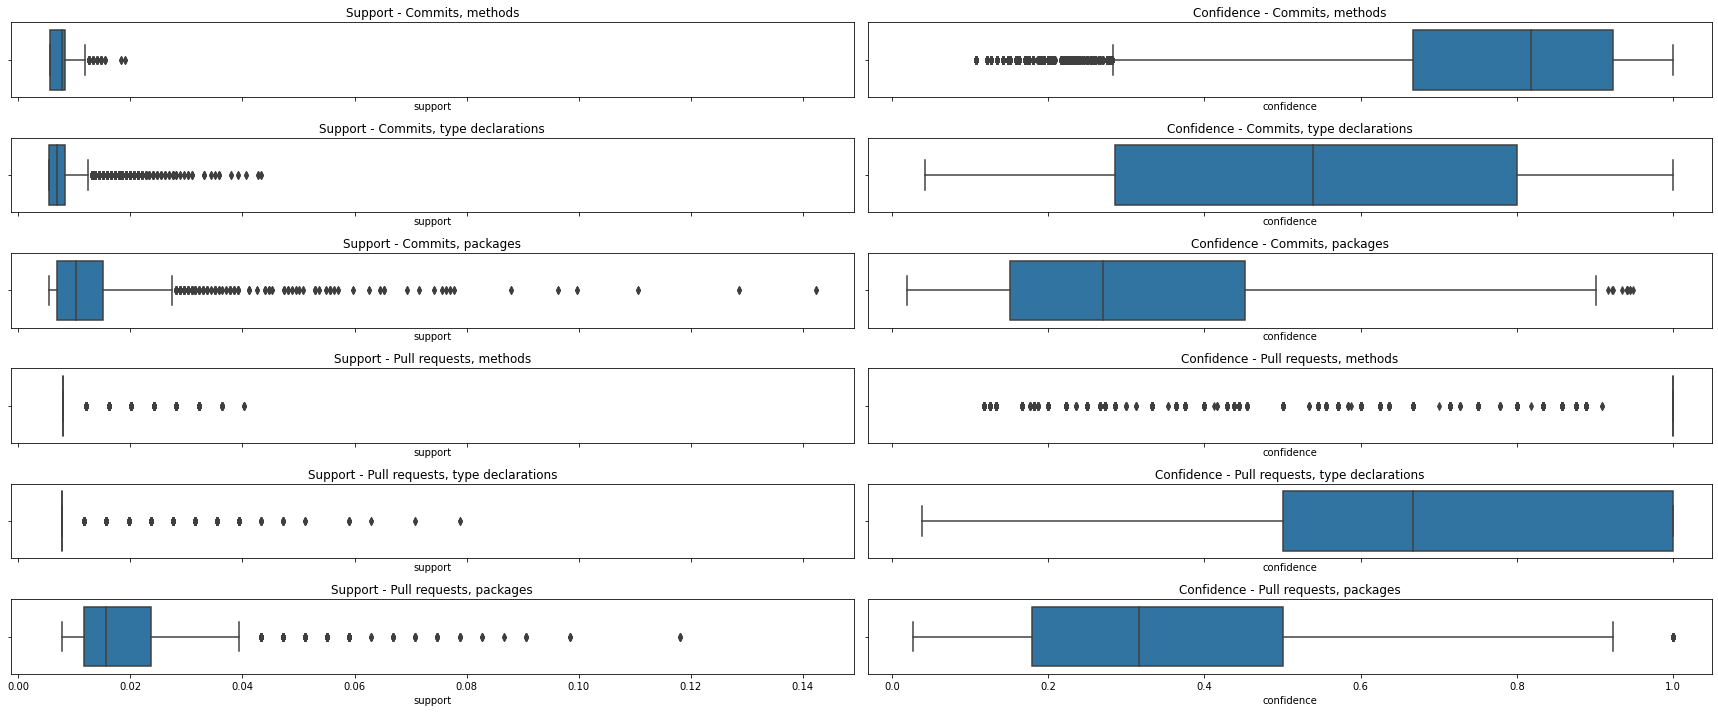

In [57]:
fig, ax = plt.subplots(nrows=len(models), ncols=2, figsize=(len(models) * 4,10), sharex='col')
for i, (s, v) in enumerate(models.items()):
    # sns.kdeplot(x=v.assoc_rules["support"], ax=ax[i, 0])
    sns.boxplot(x=v.assoc_rules["support"], ax=ax[i, 0])
    ax[i, 0].set_title(f"Support - {s}")

    # sns.kdeplot(x=v.assoc_rules["confidence"], ax=ax[i, 1])
    sns.boxplot(x=v.assoc_rules["confidence"], ax=ax[i, 1])
    ax[i, 1].set_title(f"Confidence - {s}")
fig.tight_layout()
plt.show()
